In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import scipy
%matplotlib inline
import math
import random

### Read in data

In [10]:
X = pd.read_csv("data/hw2-data/X.csv", header = None)
y = pd.read_csv("data/hw2-data/y.csv", header = None)

In [11]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

10

In [4]:
def get_pi(y): 
    return(y.sum()/len(y))

In [5]:
def get_lambdas(X,y):
    lambda_arr0 = []
    lambda_arr1 = []
    alpha = 2
    beta = 1 
    X_1 = X[y[0]==1]
    X_0 = X[y[0]==0]
    n_1 = len(X_1)
    n_0 = len(X_0)
    for idx,col in enumerate(X):
        lambda_0 = (alpha - 1 + sum(X_0[idx]))/(n_0+beta)
        lambda_1 = (alpha - 1 + sum(X_1[idx]))/(n_1+beta)
        lambda_arr0.append(lambda_0)
        lambda_arr1.append(lambda_1)
    return lambda_arr0, lambda_arr1

In [6]:
def get_prob_like(row,lambdas_0,lambdas_1,pi):
    for idx,dim in enumerate(row):
        l0 = lambdas_0[idx]
        l1 = lambdas_1[idx]
        if idx==0:
            joint_like = scipy.stats.distributions.poisson.pmf(dim,l0)
            joint_like_1 = scipy.stats.distributions.poisson.pmf(dim,l1)
        else:
            joint_like =  joint_like*scipy.stats.distributions.poisson.pmf(dim, l0)
            joint_like_1 =  joint_like_1*scipy.stats.distributions.poisson.pmf(dim, l1)
    return(joint_like*pi , joint_like_1*(1-pi)) 

p(y|x) = p(x|y=1)p(y=1) > p(x|y=0)p(y=0)

In [7]:
preds = []
actuals = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pi = get_pi(y_train)
    l0,l1 = get_lambdas(X_train,y_train)
    for idx, row in X_test.iterrows():
        p0,p1=get_prob_like(row,l0,l1,pi)
        if (p0.values>p1.values):
            out = 0
        else:
            out = 1
        preds.append(out)
        actuals.append(y_test.loc[idx].values[0])

In [8]:
matrix = np.zeros((2,2))
for a,b in zip(actuals,preds):
    if (a==0) & (b==0):
        matrix[0,0]+=1
    if (a==0) & (b==1):
        matrix[0,1] +=1 
    if (a==1) & (b==0):
        matrix[1,0] +=1
    if (a==1) & (b==1):
        matrix[1,1] +=1

In [9]:
(matrix[0,0] + matrix[1,1]) / len(X)

0.8491304347826087

In [10]:
l_averages_out = dict()
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    l0,l1 = get_lambdas(X_train,y_train)
    for i,(a,b) in enumerate(zip(l0,l1)):
        if i not in l_averages_out:
            l_averages_out[i] = [a,b]
        l_averages_out[i][0] += a
        l_averages_out[i][1] += b 

In [11]:
l0_arr=[]
l1_arr=[]
for i in range(len(X.columns)):
    vals = l_averages_out[i]
    l0_arr.append(vals[0]/10)
    l1_arr.append(vals[1]/10)

<StemContainer object of 3 artists>

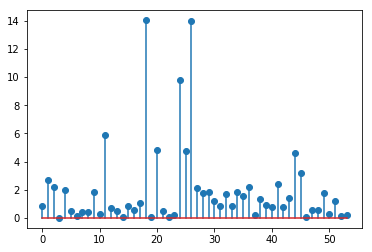

In [12]:
plt.stem(l0_arr)

<StemContainer object of 3 artists>

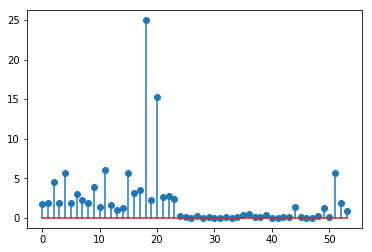

In [13]:
plt.stem(l1_arr)

In [14]:
l0_arr[15],l0_arr[51]

(0.8191282538240818, 1.2080149072899313)

In [15]:
l1_arr[15], l1_arr[51]

(5.731220357095685, 5.644068042097428)

### 2b)
Dimensions 16 and 52 have very high lambdas given y=1. This means spams tend to have more occurences of the word free and exclamation marks. On the other hand, the values are very low for y=0. There is a strong reason to believe that these two features are very predictive in identifying spams.

## 2c)

In [76]:
def distances(X_train,X_test):
    dists = np.zeros((X_test.shape[0],X_train.shape[0]))
    for i in range(X_train.shape[0]):
        l1_dist = (np.abs(X_test-X_train.T.iloc[:,i])).sum(axis=1)
        dists[:,i] = l1_dist
    return dists

In [77]:
dists = distances(X_train,X_test)

In [157]:
predictions_fin = knn_predict(dists,y_train)

In [301]:
def knn_predict(dists,y_train,y_test):
    predictions_fin = []
    for k in range(20):
        predictions =[]
        for i in range(dists.shape[0]):
            pred = 0 
            indices = dists[i,:].argsort()[:k]
            for j in indices: 
                pred += y_train.iloc[j][0]
            if pred > k/2:
                predictions.append(1)
            elif pred == k/2:
                ###break-tie with nearest one
                nearest_one = dists[i,:].argsort()[:1]
                pred = y_train.iloc[dists[i,:].argsort()[:1][0]][0]
                predictions.append(pred)
            else: 
                predictions.append(0)
        accuracy = (y_test.reset_index(drop=True)[0]==pd.Series(predictions)).sum()/len(y_test)
        predictions_fin.append(accuracy)
    return predictions_fin

In [302]:
out = dict()
for idx,(train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dists = distances(X_train,X_test)
    predictions_fin = knn_predict(dists,y_train,y_test)
    out[idx] = predictions_fin

In [321]:
accuracies_final = np.zeros(20)
for fold, accuracies in out.items():
    for k in range(20):
        accuracies_final[k] = accuracies_final[k]+accuracies[k]

In [324]:
accuracies_final = accuracies_final/10

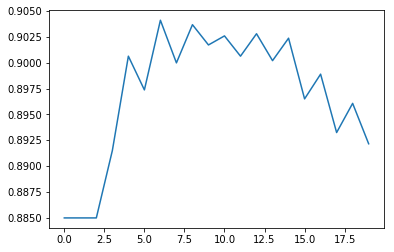

In [325]:
plt.plot(accuracies_final)

## 2d)

In [ ]:
out = dict()
for idx,(train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dists = distances(X_train,X_test)
    predictions_fin = knn_predict(dists,y_train,y_test)
    out[idx] = predictions_fin

In [12]:
y_logit = y.copy()

In [13]:
y_logit[y_logit[0]==0] = -1 

In [14]:
X_logit = X.copy()

In [15]:
X_logit['54'] = 1

In [16]:
step_size = .01/4600

In [17]:
def sigmoid_fnc(X,y,w):
    return np.exp(np.dot(X.mul(y[0],axis=0),w))/(1+np.exp(np.dot(X.mul(y[0],axis=0),w)))

In [18]:
def calc_logistic(X_logit,y_logit):
    wo = np.zeros(len(X_logit.columns))
    wt = wo
    out = []
    for i in range(1000):
        likelihood = sigmoid_fnc(X_logit,y_logit,wt)
        sum_=np.matmul((1-likelihood)*y_logit[0],X_logit)
        out.append(np.sum(np.log(likelihood)))
        wt += step_size*sum_
    return wt,out

In [19]:
weight, likelihood = calc_logistic(X_logit,y_logit)

In [20]:
weight

array([-0.03790831, -0.02131815,  0.00466749,  0.06457986,  0.04139521,
        0.06028444,  0.2207414 ,  0.04713583,  0.09117704,  0.00785039,
        0.00113874, -0.02795729, -0.02016927,  0.0067646 ,  0.10131869,
        0.09683928,  0.09705903,  0.00780486, -0.00596844,  0.12005358,
        0.01814155,  0.02615016,  0.22927385,  0.07003464, -0.20139477,
       -0.12141729, -0.3227921 ,  0.03228998, -0.13992516, -0.05468975,
       -0.03386868, -0.01469066, -0.09932062, -0.01111592, -0.09684777,
        0.04274398, -0.015638  , -0.06366767, -0.09339494, -0.0405037 ,
       -0.11531853, -0.18984293, -0.08587124, -0.17451997, -0.09081207,
       -0.17934204, -0.06591368, -0.11995556, -0.12646998, -0.05766427,
       -0.07272841,  0.02870333,  0.32271507,  0.10218202, -0.21282262])

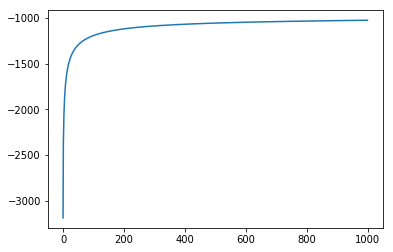

In [43]:
plt.plot(out)

## 2e)

In [22]:

from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_logit,y_logit)

In [27]:
lr.predict(X_logit)

array([[-0.07005097],
       [ 0.38075226],
       [ 0.97234412],
       ..., 
       [-0.31978393],
       [-0.62880811],
       [-0.5977939 ]])

In [32]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

In [33]:
def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum( target*scores - np.log(1 + np.exp(scores)) )
    return ll

In [37]:
def logistic_regression(features, target, num_steps, learning_rate, add_intercept = False):
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))
        
    weights = np.zeros(features.shape[1])
    
    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        # Update weights with gradient
        output_error_signal = target - predictions
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient

        
    return weights

In [38]:
weights = logistic_regression(X, y,
                     num_steps = 1000, learning_rate = step_size, add_intercept=True)

ValueError: Unable to coerce to Series, length must be 1: given 4600